In [1]:
cd /content/drive/My Drive/Colab Notebooks/new_sateliteImage

/content/drive/My Drive/Colab Notebooks/new_sateliteImage


In [2]:
ls

'archive (3).zip'            dataset.py                     __pycache__/
 checkpoint/                 dataset.pyc                    runs/
 checkpoint_ssd300.pth.tar   engine.py                      split_data.py
 chkpoint_                   engine.pyc                     test_data_images/
 coco_eval.py                evaluate.py                    train.py
 coco_utils.py               inference.ipynb                transforms.py
 coco_utils.pyc              Oct21_04-00-41_dfff1a48e47f/   transforms.pyc
 data/                       predict.py                     utils.py


In [3]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np
import os
import cv2
import random
import argparse

In [4]:
imgs = os.listdir('test_data_images/test_data_images/images/')
len(imgs)

2703

In [5]:
import pdb
CLASS_NAMES = ["__background__", "car","pool"]
def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold value for prediction score
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - class, box coordinates are obtained, but only prediction score > threshold
          are chosen.
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img).to(device)
    # pdb.set_trace()
    pred = model['state_dict'](img)
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())

    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
 
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score

def detect_object(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=1):
    """
    object_detection_api
      parameters:
        - img_path - path of the input image
        - confidence - threshold value for prediction score
        - rect_th - thickness of bounding box
        - text_size - size of the class label text
        - text_th - thichness of the text
      method:
        - prediction is obtained from get_prediction method
        - for each prediction, bounding box is drawn and text is written 
          with opencv
        - the final image is displayed
    """
    boxes, pred_cls, pred_score = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(len(boxes))
    for i in range(len(boxes)):
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i]+": "+str(round(pred_score[i],3)), boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [6]:
from train import build_model, get_transform
from dataset import SatelliteDataset
import transforms as T
import utils
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch import Tensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

dataset_test = SatelliteDataset('test_data_images/test_data_images/images/', get_transform(train=False))
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)
# pdb.set_trace()
model = build_model(3)
rand_img = random.sample(imgs, 1) 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoint = torch.load("./checkpoint/chkpoint_9.pt", map_location={'cuda:0': 'cpu'})
model.load_state_dict(checkpoint['state_dict'])
model.eval()
# pdb.set_trace()
img_path = os.path.join(os.getcwd(), "test_data_images/test_data_images/images", rand_img[0])
img_path = os.path.join(os.getcwd(), "test_data_images/test_data_images/images", "000000001.jpg")
# img_path = "images/blueangels.jpg"
# prev_time = time.time()
# img = Image.open(img_path)
# img_transforms=transforms.Compose([
#       transforms.ToTensor(),
#       ])
# # convert image to Tensor
# image_tensor = img_transforms(img).float()
# image_tensor = image_tensor.unsqueeze_(0)
# input_img = Variable(image_tensor.type(Tensor))
# res = model(input_img)
# print(res)
# # Get bounding-box colors
# cmap = plt.get_cmap('tab20b')
# colors = [cmap(i) for i in np.linspace(0, 1, 20)]
# img = np.array(img)
# plt.figure()
# fig, ax = plt.subplots(1, figsize=(12,9))
# ax.imshow(img)
# detections = res[0]['boxes']
# if detections is not None:
#     unique_labels = detections[:, -1].cpu().unique()
#     n_cls_preds = len(unique_labels)
#     bbox_colors = random.sample(colors, n_cls_preds)
#     # browse detections and draw bounding boxes
#     for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
#         box_h = ((y2 - y1) / unpad_h) * img.shape[0]
#         box_w = ((x2 - x1) / unpad_w) * img.shape[1]
#         y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
#         x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
#         color = bbox_colors[int(np.where(
#              unique_labels == int(cls_pred))[0])]
#         bbox = patches.Rectangle((x1, y1), box_w, box_h,
#              linewidth=2, edgecolor=color, facecolor='none')
#         ax.add_patch(bbox)
#         plt.text(x1, y1, s=classes[int(cls_pred)], 
#                 color='white', verticalalignment='top',
#                 bbox={'color': color, 'pad': 0})
# plt.axis('off')
# # save image
# plt.savefig(img_path.replace(".jpg", "-det.jpg"),        
#                   bbox_inches='tight', pad_inches=0.0)
# plt.show()
# detect_object(img_path, confidence=0.7)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [14]:
def get_prediction(model, img_path, threshold):
  img = Image.open(img_path) # Load the image
  my_transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
  img = my_transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  # pdb.set_trace()
  pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  print(len(pred_boxes))
  print(pred)
  return pred_boxes, pred_class

def object_detection_api(img_path, model, threshold=0.5, rect_th=1, text_size=3, text_th=3):

  boxes, pred_cls = get_prediction(model, img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    # cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=1) # Write the prediction class
  # plt.figure(figsize=(20,30)) # display the output image
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

# print(get_prediction(model, img_path, 0.5))


9
[{'boxes': tensor([[4.6674e+01, 1.3426e+01, 5.7806e+01, 2.4637e+01],
        [3.1341e+01, 1.0252e+01, 4.2387e+01, 2.1390e+01],
        [1.6655e+02, 1.2617e+02, 1.7776e+02, 1.3729e+02],
        [1.4761e+02, 1.2540e+02, 1.5876e+02, 1.3651e+02],
        [2.0303e+02, 1.6915e+01, 2.1417e+02, 2.7610e+01],
        [1.8265e+01, 1.2527e+02, 2.9634e+01, 1.3636e+02],
        [1.9907e+02, 0.0000e+00, 2.1004e+02, 7.2322e+00],
        [2.1777e+02, 9.0449e+00, 2.2400e+02, 2.0071e+01],
        [2.2033e+02, 9.1905e+00, 2.2342e+02, 1.9821e+01],
        [1.9880e+02, 7.0756e-02, 2.0959e+02, 3.8313e+00],
        [2.2276e+02, 9.7602e+00, 2.2400e+02, 1.9699e+01],
        [2.2108e+02, 7.8514e+00, 2.2400e+02, 1.7770e+01]],
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9992, 0.9991, 0.9989, 0.9988, 0.9949, 0.9901, 0.9882, 0.9869, 0.6770,
        0.3452, 0.2045, 0.0674], grad_fn=<IndexBackward>)}]


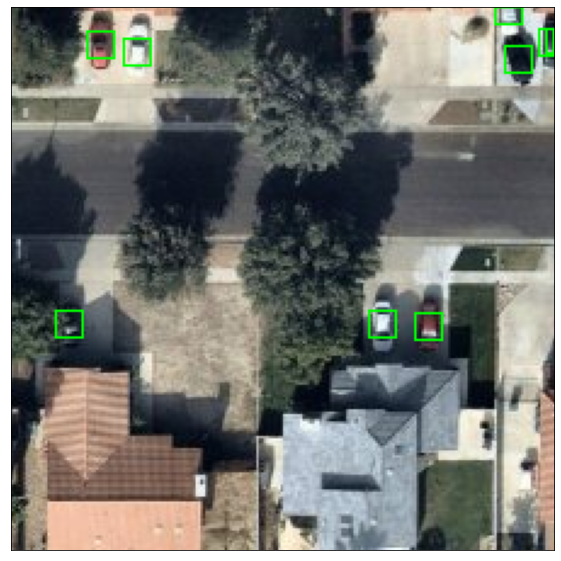

In [15]:
img_path = os.path.join(os.getcwd(), "test_data_images/test_data_images/images", "000000006.jpg")
object_detection_api(img_path, model)

000002503.jpg
(<PIL.Image.Image image mode=RGB size=224x224 at 0x7FA3D7013E80>, {'boxes': tensor([[ 17.0100,  28.5600,  28.1200,  39.6700],
        [177.0300,   0.6300, 188.1400,  11.7400],
        [185.1700,  13.3700, 196.2900,  24.4900],
        [113.2700, 213.5700, 124.3800, 224.0000],
        [113.9900, 189.7600, 125.1100, 200.8700]]), 'labels': tensor([1, 1, 1, 1, 1]), 'image_id': tensor([2]), 'area': tensor([123.4321, 123.4321, 123.6543, 115.8772, 123.5432]), 'iscrowd': tensor([0, 0, 0, 0, 0])})
tensor([[ 17.0100,  28.5600,  28.1200,  39.6700],
        [177.0300,   0.6300, 188.1400,  11.7400],
        [185.1700,  13.3700, 196.2900,  24.4900],
        [113.2700, 213.5700, 124.3800, 224.0000],
        [113.9900, 189.7600, 125.1100, 200.8700]])


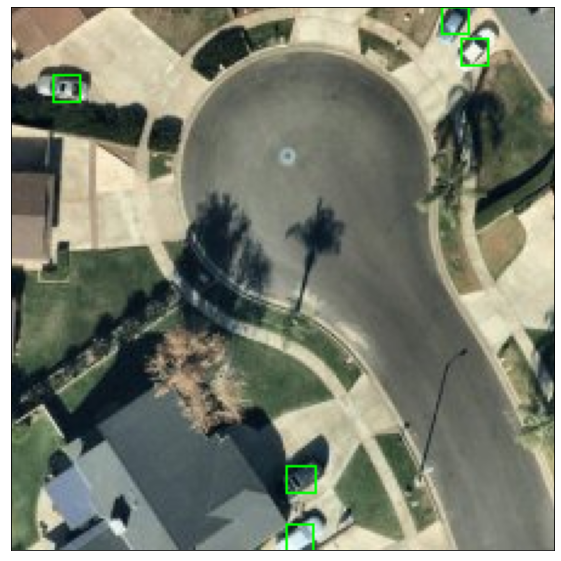

In [ ]:
from dataset import SatelliteDataset
a= SatelliteDataset('data/training_data/images')
idx = 2
print(a.lst_images[idx])
print(a.__getitem__(idx))
res = a.__getitem__(idx)
img_path = 'data/training_data/images/' + a.lst_images[idx]
img = cv2.imread(img_path) # Read image with cv2
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
_, img_info = a.__getitem__(idx)
boxes = img_info['boxes']
print(boxes)
boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(boxes.detach().numpy())]
boxes
for i in range(len(boxes)):
  cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=1) # Draw Rectangle with the coordinates
  # cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=1) # Write the prediction class
# plt.figure(figsize=(20,30)) # display the output image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()